In [1]:
import os
import sys
sys.path.append('..')
import torch
import librosa
from scipy.io import wavfile
from IPython import display as disp
from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt

from src.modules import VocosVocoderModule

/mnt/data2/waris/envs/darkstream/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/mnt/data2/waris/envs/darkstream/lib/python3.10/site-packages/speechbrain/utils/torch_audio_backend.py:57: UserWarning: torchaudio._backend.list_audio_backends has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/audio/issues/3902 for more information. It will be removed from the 2.9 release. 
  available_backends = torchaudio.list_audio_backends()


In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = "2" # Set the GPU device
MAX_WAV_VALUE = 32768.0

In [3]:
model = VocosVocoderModule.load_from_checkpoint(
    '../ckpts/epoch=3.ckpt',
    map_location="cpu",
)

model.eval()

/mnt/data2/waris/envs/darkstream/lib/python3.10/site-packages/torch/nn/utils/weight_norm.py:144: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


VocosVocoderModule(
  (feature_extractor): StreamingLogMelSpectrogram(
    (conv): RawStreamingLogMelSpectrogram(
      (spectrogram): LinearSpectrogram()
    )
  )
  (decoder): Sequential(
    (0): VocosBackbone(
      (embed): StreamingConv1d(
        (conv): NormConv1d(
          (conv): RawStreamingConv1d(80, 512, kernel_size=(7,), stride=(1,))
        )
      )
      (norm): LayerNorm((512,), eps=1e-06, elementwise_affine=True)
      (convnext): ModuleList(
        (0-7): 8 x ConvNeXtBlock(
          (dwconv): StreamingConv1d(
            (conv): NormConv1d(
              (conv): RawStreamingConv1d(512, 512, kernel_size=(7,), stride=(1,), groups=512)
            )
          )
          (norm): LayerNorm()
          (pwconv1): Linear(in_features=512, out_features=1536, bias=True)
          (act): GELU(approximate='none')
          (pwconv2): Linear(in_features=1536, out_features=512, bias=True)
          (drop_path): Identity()
          (add): StreamingAdd()
        )
      )
    

In [4]:
wav_file = "../sample_wav/BDL/arctic_a0001.wav"
_device = "cpu"
sample_rate = 16000

audio, _ = librosa.load(wav_file, sr=sample_rate)

disp.Audio(audio, rate=16000)

In [5]:
audio = torch.from_numpy(audio).unsqueeze(0).unsqueeze(0).to(_device)
mel_spec = model.feature_extractor(audio)

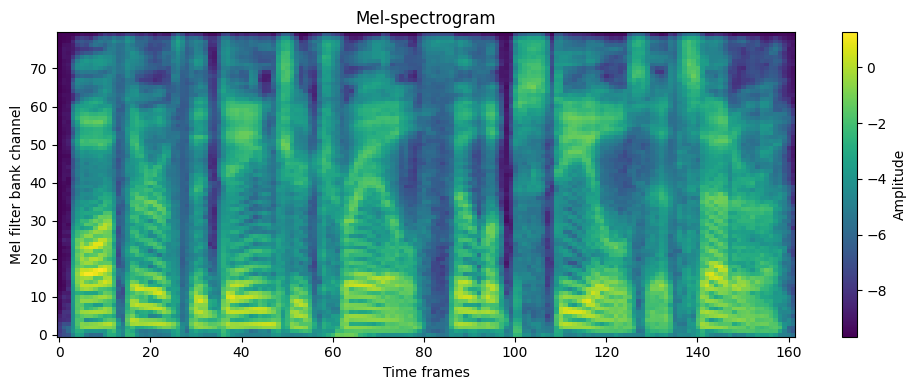

In [6]:
# mel: torch.Tensor of shape (80, T)
mel_np = mel_spec.squeeze().cpu().numpy()  # -> (80, T)

plt.figure(figsize=(10, 4))
plt.imshow(mel_np, aspect='auto', origin='lower')
plt.xlabel('Time frames')
plt.ylabel('Mel filter bank channel')
plt.title('Mel‑spectrogram')
plt.colorbar(label='Amplitude')
plt.tight_layout()
plt.show()


In [7]:
# mel to wav
with torch.no_grad():
    audio_out = model(mel_spec)
    audio_out = audio_out.squeeze().cpu().numpy()
    # audio_out = audio_out * MAX_WAV_VALUE
    # audio_out = audio_out.astype('int16')

disp.Audio(audio_out, rate=16000)

In [9]:
# streaming generation
chunk_size = 1
with torch.no_grad(), model.decoder[0].streaming(1), model.decoder[1].streaming(1):
    audio_out_stream = []
    for mel in tqdm(mel_spec.split(chunk_size, dim=2)):
        audio_out_stream.append(model(mel))
    audio_out_stream = torch.cat(audio_out_stream, dim=2).squeeze().cpu().numpy()

disp.Audio(audio_out_stream, rate=16000)

100%|██████████| 162/162 [00:01<00:00, 89.76it/s]
